# Imports

In [2]:
from scikits.talkbox.features import mfcc
from scikits.audiolab import wavread
from matplotlib import pyplot as plt
import numpy as np
import librosa
import speakerID
import pickle
import vad
%matplotlib inline
#import seaborn
#seaborn.set(style='ticks')
#seaborn.color_palette("muted")

from IPython.display import display, Audio

/usr/local/lib/python2.7/site-packages/librosa/core/audio.py:37: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Explore data

In [3]:
data, fs, enc = wavread('data/AudioData/DC/a01.wav')
np.shape(data)
display(Audio(data = data, rate = fs))

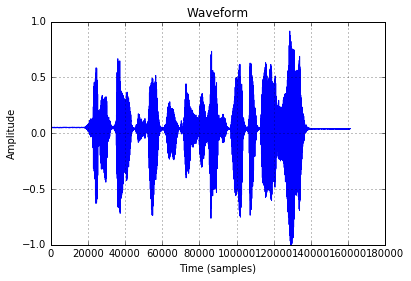

In [4]:
plt.plot(data)
plt.title('Waveform')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.grid(True)

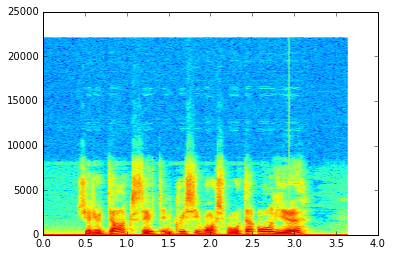

In [5]:
#NFFT = 8192
NFFT = 1024
plt.specgram(data, NFFT=NFFT, Fs=fs)
plt.show()

# Voice Activity detection

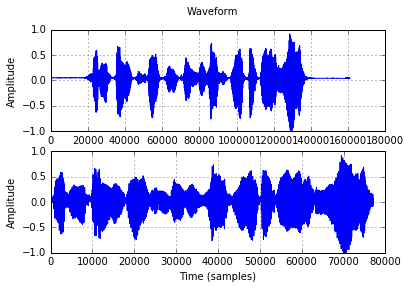

In [6]:
# if energy is <15% of average energy => unvoiced
new = vad.remove_silence(fs, data)
plt.subplot(2,1,1)
plt.plot(data)
plt.ylabel('Amplitude')
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(new)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.suptitle('Waveform')
plt.grid(True)


# Feature Extraction

In [7]:
MFCCs, mspec, spec = mfcc(new, nwin=256, nfft=512, fs=fs, nceps=13)
np.shape(MFCCs)
mfcc = librosa.feature.mfcc(y = new, sr = fs, n_mfcc = 13, hop_length = 512)

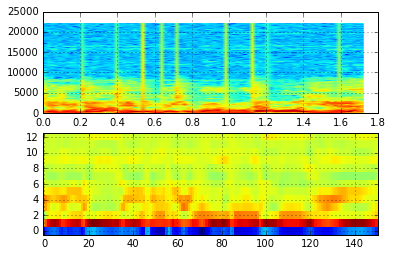

In [8]:
#fig, ax = plt.subplots(1, 1, sharey=True, figsize=(15, 3.5
plt.subplot(2,1,1)
plt.specgram(new, NFFT=NFFT, Fs=fs)
plt.grid(True)
plt.subplot(2,1,2)
plt.imshow(mfcc, origin="lower", aspect="auto",  interpolation="nearest")
plt.grid(True)

# Speaker identification

In [9]:
Speaker = speakerID.speakerID()

In [10]:
dc, fs, enc = wavread('data/AudioData/DC/a01.wav')
display(Audio(data = dc, rate = fs))
je, fs, enc = wavread('data/AudioData/JE/a01.wav')
display(Audio(data = je, rate = fs))
jk, fs, enc = wavread('data/AudioData/JK/a01.wav')
display(Audio(data = jk, rate = fs))

### Train GMM for each speaker

In [11]:
Speaker.enroll('DC', dc)
Speaker.enroll('JE', je)
Speaker.enroll('JK', jk)

In [12]:
Speaker.train()

In [13]:
Speaker.dump('simple_speaker.model')

In [14]:
Speaker.recognize(data, step=5, fs=fs, disp = False)

Recognition results:
('0:00:00', 'DC')


### Test new audio

In [15]:
je2, fs, enc = wavread('data/AudioData/JE/a01.wav')
jk2, fs, enc = wavread('data/AudioData/JK/n14.wav')

In [16]:
Speaker.recognize(je2)

Recognition results:
('0:00:00', 'JE')


('0:00:01', 'JE')


('0:00:02', 'JE')


# Train test on reduced dataset

Extract from SAVEE dataset: 4 male english speakers: 15 sentences for 6 emotional categories + 30 for neutral = 120 samples of 3 s. each (~ 200MB of data ~30 min)

In [17]:
# ./split.py script in data/AudioData randomly splits into training/test sets 

In [18]:
[train, test] = pickle.load(open('data/AudioData/data.pkl', 'rb'))

In [19]:
for speaker in ['DC', 'JE', 'JK']:
    for audio in train[speaker]:
        signal, fs, enc = wavread('data/AudioData/'+speaker+'/'+audio)
        Speaker.enroll(speaker, signal)

In [20]:
Speaker.train()

In [21]:
Speaker.dump('speaker.model')

### Predictions on the test set:

In [22]:
for speaker in ['DC', 'JE', 'JK']:
    print "----- " + speaker + " -------"
    for audio in test[speaker]:
        signal, fs, enc = wavread('data/AudioData/'+speaker+'/'+audio)
        print "predict: "+Speaker.predict(signal,fs=fs)


----- DC -------
predict: DC
predict: DC
predict: DC
predict: DC
predict: DC
predict: DC
predict: DC
predict: DC
predict: DC
predict: DC
predict: DC
predict: DC
----- JE -------
predict: JE
predict: JE
predict: JE
predict: JK
predict: JE
predict: JE
predict: JE
predict: JE
predict: JE
predict: JE
predict: JE
predict: JE
----- JK -------
predict: JK
predict: JK
predict: JK
predict: JK
predict: JK
predict: JK
predict: JK
predict: DC
predict: JK
predict: JK
predict: JK
predict: JK


#### Classification accuracy for DC, JE and JK:
+ DC: 9/12 (75%)
+ JE: 12/12 (100%)
+ JK: 9/12 (75%) 
+ overall: 83%

## Feature extraction + prediction computation time

In [23]:
import timeit
from time import time
t0 = time()
Speaker.predict(je2)
t1 = time()
print "time in seconds: ", t1-t0
#t = timeit.Timer(Speaker.predict(je2))

time in seconds:  0.13947892189


## Prediction on small window sizes (500ms)

In [49]:
# print test['DC']
test, fs, enc = wavread('data/AudioData/DC/sa11.wav')
print "----- test DC ----"
Speaker.recognize(test, duration=0.5, step=0.5)
print "----- test JE ----"
test, fs, enc = wavread('data/AudioData/JE/sa11.wav')
Speaker.recognize(test, duration=0.5, step=0.5)

----- test DC ----
Recognition results:
('0:00:00', 'JE')


('0:00:00', 'DC')


('0:00:01', 'DC')


('0:00:01', 'DC')


('0:00:02', 'DC')


('0:00:02', 'JE')


('0:00:03', 'DC')


('0:00:03', 'DC')


('0:00:04', 'DC')


('0:00:04', 'DC')


('0:00:05', 'DC')


('0:00:05', 'DC')


----- test JE ----
Recognition results:
('0:00:00', 'JE')


('0:00:00', 'JE')


('0:00:01', 'JE')


('0:00:01', 'JE')


('0:00:02', 'JE')


('0:00:02', 'JE')


('0:00:03', 'JE')


('0:00:03', 'DC')


('0:00:04', 'JE')


('0:00:04', 'JE')
